# Part II - Ford Go Bike System Usage Pattern Feb'19
## by Matthew Chan

## Investigation Overview

> A regional bike-sharing program called Ford GoBike operates in the Californian San Francisco Bay Area. With approximately 500,000 rides since its debut in 2017, Ford GoBike is the first regional and extensive bicycle sharing system set up in California and along the West Coast of the United States. As of January 2018, it has about 10,000 annual subscribers. The primary goal of this investigation and visualization project is to identify consumer habits and bike usage patterns using data from one month's worth of riding trips in February of 2019.


## Dataset Overview

> The dataset presents a daily view of individual users trip data in February 2019. The information was stored in a comma-separated values file (csv) and contains 183,412 rows of datapoints. 

In [24]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [25]:
# load in the dataset into a pandas dataframe
bike_df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [26]:
# defining a function to explore and summarize datasets

def summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns the data type, # of null rows and unique rows of a given dataframe
    
    Args: 
        A dataframe of n_rows and n_columns
    Returns:
        A dataframe of 4 columns [data_type, non-null-rows, unique_rows, missing_rows]
    """
    concat = pd.concat(
        [df.dtypes.to_frame(), df.count().to_frame(), df.nunique(), df.isnull().sum()], axis=1
    )
    concat.columns = ['data_type', 'non-null-rows', 'unique_rows', 'missing_rows']
    return concat

In [27]:
# cleaning up the dataset

# casting the following variables into their correct/appropriate datatypes
bike_df = (
    bike_df
    .astype({'start_time': 'datetime64[ns]',
             'end_time': 'datetime64[ns]',
             'start_station_id': 'str',
             'end_station_id': 'str',
             'bike_id': 'str',
             'member_gender': 'category',
             'user_type': 'category'})
)

# adding age of riders 'age' column into dataset
# adding new columns - 'date, hour, day and month' for datetime formats
bike_df = (
    bike_df
    .assign(age=lambda a: 2022-a.member_birth_year,
            start_date=lambda sd: sd.start_time.dt.strftime('%Y-%m-%d'),
            start_hour=lambda x: x.start_time.dt.strftime('%H'),
            start_day=lambda x: x.start_time.dt.strftime('%A'),
            start_month=lambda x: x.start_time.dt.strftime('%B'))
)

# removing null/na numbers of members without age
bike_df = bike_df.dropna(subset=['age'])
# casting age into appropriate datatype (int)
bike_df = bike_df.astype({'age': 'int32'})

summary(bike_df)

,data_type,non-null-rows,unique_rows,missing_rows
duration_sec,int64,175147,4432,0
start_time,datetime64[ns],175147,175136,0
end_time,datetime64[ns],175147,175134,0
start_station_id,object,175147,330,0
start_station_name,object,174952,329,195
start_station_latitude,float64,175147,334,0
start_station_longitude,float64,175147,335,0
end_station_id,object,175147,330,0
end_station_name,object,174952,329,195
end_station_latitude,float64,175147,335,0


## User Types and their Daily Usage by Day

> Subscribers contribute to a significant majority of bike trips in February 2019 of around 90.5%, while the other 9.5% was made up of customers. Both subscribers and customers typically had a peak usage period on Thursday and dipped in usage for the weekends (Saturday and Sunday). 

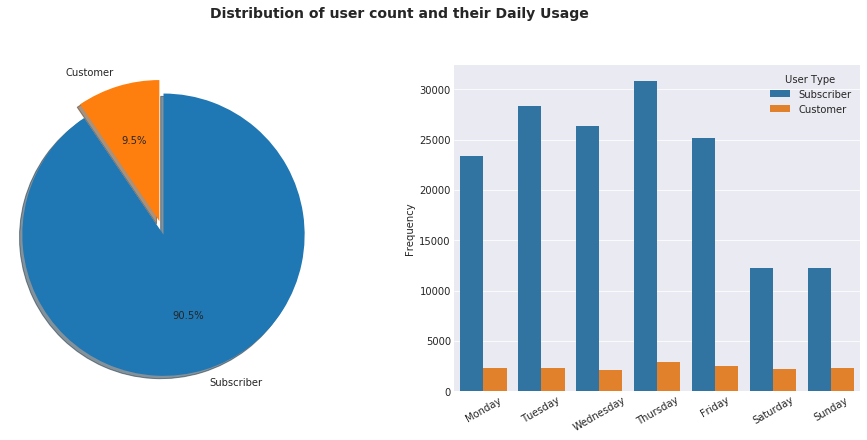

In [28]:
plt.figure(figsize=[16, 6]);
base_color = sb.color_palette('colorblind')[0];
sns.set_style('darkgrid');

plt.subplot(1, 2, 1);
sorted_vals = bike_df.user_type.value_counts()/bike_df.shape[0];
plt.pie(sorted_vals, explode=[0, 0.1], labels=sorted_vals.index, startangle=90, counterclock=False, autopct='%1.1f%%', shadow=True);
plt.axis('square');

plt.subplot(1, 2, 2);
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_of_week_cat = pd.api.types.CategoricalDtype(ordered=True, categories=days_of_week)
bike_df = bike_df.astype({'start_day': days_of_week_cat})

ax = sns.countplot(data=bike_df, x='start_day', hue='user_type', hue_order=sorted_vals.index);
ax.legend(title='User Type');
plt.xticks(rotation=30);
plt.xlabel('');
plt.ylabel('Frequency');
plt.suptitle('Distribution of user count and their Daily Usage', fontsize=14, fontweight='semibold', y=1.015);

## Average trip duration in days of the week between user types

> As observed from the point plot, in general:

Customers took longer trips as compared to Subscribers
There is an increase (though more significant in Customers) on increase in trip duration during the weekends
The error bars give us an insight into the measure of central tendency between both user types, whereby customers typically have a much wider spread in trip duration - which is unlike the Subscribers who had a much more concentrated data spread, indicating that users are more likely to have a trip duration close to the median.
This might be due to the terms of bike duration per trip (e.g, Subscribers have free trips for the first xx minutes, thereafter incurring additional charges after the daily free trip duration.)


Text(0,0.5,'Trip Duration (min)')

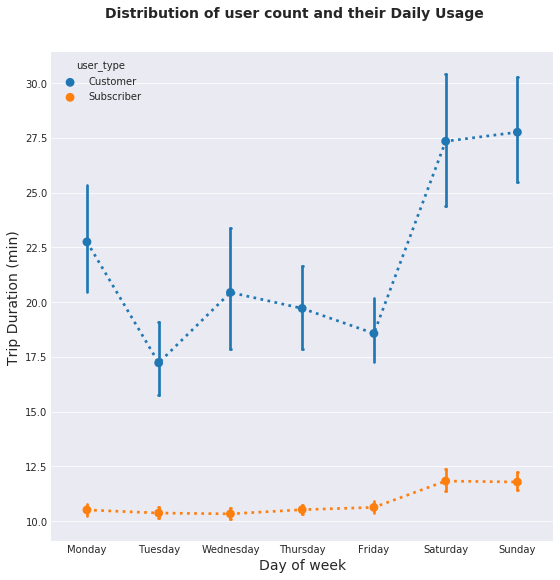

In [33]:
# figure size
plt.figure(figsize=[9,9])

# creating a minute column
bike_df['duration_min'] = bike_df['duration_sec']/60

# creating our pointplot
sns.pointplot(data=bike_df, x='start_day', y='duration_min', hue='user_type', capsize=0.01, linestyles=":")

# set title of the barplot
plt.suptitle('Distribution of user count and their Daily Usage', fontsize=14, fontweight='semibold', y=0.95);
# set x_label of plot
plt.xlabel('Day of week', fontsize=14)
# set y_label of plot
plt.ylabel('Trip Duration (min)', fontsize=14)

## Hourly usage between user types across days of the week

> It is obvious that the two types of riders have different usage patterns and behaviors. On weekdays, Monday through Friday, subscribers made heavy use of the system, although weekend ridership was higher, especially in the afternoon. When utilized for commuting to work, subscribers made a lot of journeys between 8 and 9 am and 5 to 6 pm on weekdays. However, non-subscribers tended to make more trips between 5 and 6 pm, Monday through Friday. In addition to the various usage objectives, it could also be related to the local traffic conditions during these rush hours.

In [11]:
# defining a function to transform our dataset
def heatmap_transform(df: pd.DataFrame, target:str) -> pd.DataFrame:
    """
    Returns a pivot table of frequency count per day, by the hour
    
    Args: 
        df - A dataframe of n_rows and n_columns
        target - user type we are interested in filtering for
    Returns:
        A pivot table
    """
    
    transformed_df = (
        df
        # filter out for given target argument
        .query(f'user_type == "{target}"')
        .groupby(['start_day', 'start_hour'])
        .size()
        .reset_index(name='count')
        .pivot(index='start_day', columns='start_hour', values='count')
        .fillna(0)
    )
    
    return transformed_df

cust_count = heatmap_transform(bike_df, 'Customer')

subs_count = heatmap_transform(bike_df, 'Subscriber')

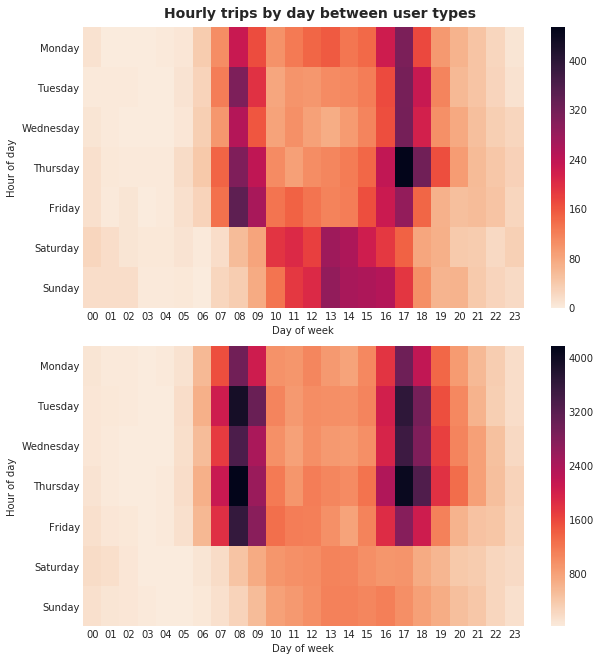

In [19]:
# figure size
plt.figure(figsize=[9,9])

# set title of the barplot
plt.suptitle('Hourly trips by day between user types', fontsize='14', fontweight='semibold', y=1.015)

# defining subplot 1
plt.subplot(2,1,1)
sns.heatmap(cust_count, cmap='rocket_r')
# set x_label of plot 1
plt.xlabel('Day of week', fontsize=10)
# set y_label of plot 1
plt.ylabel('Hour of day', fontsize=10)


# defining subplot 2
plt.subplot(2,1,2)
sns.heatmap(subs_count, cmap='rocket_r')
# set x_label of plot 2
plt.xlabel('Day of week', fontsize=10)
# set y_label of plot 2
plt.ylabel('Hour of day', fontsize=10)

plt.tight_layout()

## Summary

> Overall, there were a lot more subscribers than casual users of the bike-sharing system; both use it the most in the weekdays and fewer during the weekends. Clearly, the two groups of cyclists exhibit various usage patterns and riding behaviors. For work-related commuting, subscribers tended to use the system heavily around periods of 8am and 5pm, whereas consumers often ride more on weekends and in the late afternoon. Subscriber usage is more effective because subscribers often have shorter, quicker travels than customers.

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_slide_deck.ipynb to slides
[NbConvertApp] Writing 439188 bytes to Part_II_slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Part_II_slide_deck.slides.html
Use Control-C to stop this server
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: x-www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: firefox: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: iceweasel: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: seamonkey: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: mozilla: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: epiphany: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: konqueror: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: chromium-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: google-chrome: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: www-browser: not 